In [1]:
import sys
sys.path.append('/home/jhernandez/Work//')
sys.path.append('/home/jhernandez/Work/python_tools/')

from defaults import *

import pyroms

## **Assess impact of DA. EuroSea WP2 OSSE experiment.** 
#### (Hindcast: Compare Obs - Analysis - After Nudging)

### **Check Fields in Depth**

   Check results of the **Hindcast fields**. 
   
   
   - Salinity and Temperature fields are compared whithin simulations and with the CTD pseudo-obs
   - Surface currents and SSH in the area are compared between simulations

#### Load Pseudo-Obs created by Barbara

In [2]:
file_obs = '/LOCALDATA/Data/EuroSea_WP2/eNATL60_pseudo-obs/Med_conf_r_dep_1000m_res_10km_Sep_eNATL60.nc'

In [3]:
ds_obs = xr.open_dataset(file_obs, decode_times=False)

In [4]:
time_ctd = [datetime(1,1,1) + timedelta( float(dt)) for dt in list(ds_obs.time_ctd.values)]
time_adcp = [datetime(1,1,1) + timedelta( float(dt)) for dt in list(ds_obs.time_adcp.values)]

save_time_label = (datetime(1,1,1) + timedelta(float(ds_obs.time_adcp.max() )) ).strftime('%b%Y')

In [5]:
dl = 0.1
limits_obs = [float(ds_obs.lon_ctd.min().values) - dl,
              float(ds_obs.lon_ctd.max().values) + dl,
              float(ds_obs.lat_ctd.min().values) - dl,
              float(ds_obs.lat_ctd.max().values) + dl
             ]

## **AFTER NUDGING**

#### **Define Date**

In [119]:
date = datetime(2009,9,5)
date_yesterday = date - timedelta(days=1)
#date = time_ctd[0]

#### **Fields eNATL60**

In [6]:
path_enatl60 = '/LOCALDATA/Data/eNATL60/'

In [133]:
file_temp_natl = F"{path_enatl60}/WMED_3D-fields/eNATL60MEDWEST-BLB002_y{date.strftime('%Ym%md%d')}.1h_votemper.nc"
file_salt_natl = F"{path_enatl60}/WMED_3D-fields/eNATL60MEDWEST-BLB002_y{date.strftime('%Ym%md%d')}.1h_vosaline.nc"

natl_temp = xr.open_dataset(file_temp_natl)
natl_salt = xr.open_dataset(file_salt_natl)

file_wmop = glob(F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/{date.strftime('%Y/%m/%d')}/*avg.nc")[0]
ds_wmop = xr.open_dataset(file_wmop)

In [16]:

bath_natl = xr.open_dataset('/LOCALDATA/Data/eNATL60/eNATL60MEDWEST_BATHY_GEBCO_2014_2D_msk_v3.1_lb.nc4')
mask_natl = xr.open_dataset('/LOCALDATA/Data/eNATL60/mask_eNATL60MEDWEST_3.6.nc')

#### **Load WMOP**

In [266]:
file_wmop = glob(F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/{date.strftime('%Y/%m/%d')}/*avg.nc")[0]
ds_wmop = xr.open_dataset(file_wmop)

file_wmop_mdt = '/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/7year_mean/roms_WMOP_HINDCAST_regular_avg_7yearmean.nc'
ds_wmop_mdt = xr.open_dataset(file_wmop_mdt)

grd = pyroms.grid.get_ROMS_grid('grid', hist_file=file_wmop, grid_file=file_wmop)

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


#### **Load DA Analysis**

In [17]:
obs_labels = ['CTD', 'SLA-v1_SST_Argo', 'SLA-v1_SST_Argo_CTD-v4']
path_da = '/mnt/vinson/DATA/jhernandez/ROMS/Outputs/EuroSea_OSSE_nudging/'

ds_da = xr.open_dataset(F"{path_da}{obs_labels[1]}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc")

In [34]:
ds_obs.dep_ctd.values

array([   5. ,    5.5,    6. , ...,  999. ,  999.5, 1000. ], dtype=float32)

### Plot Salinity

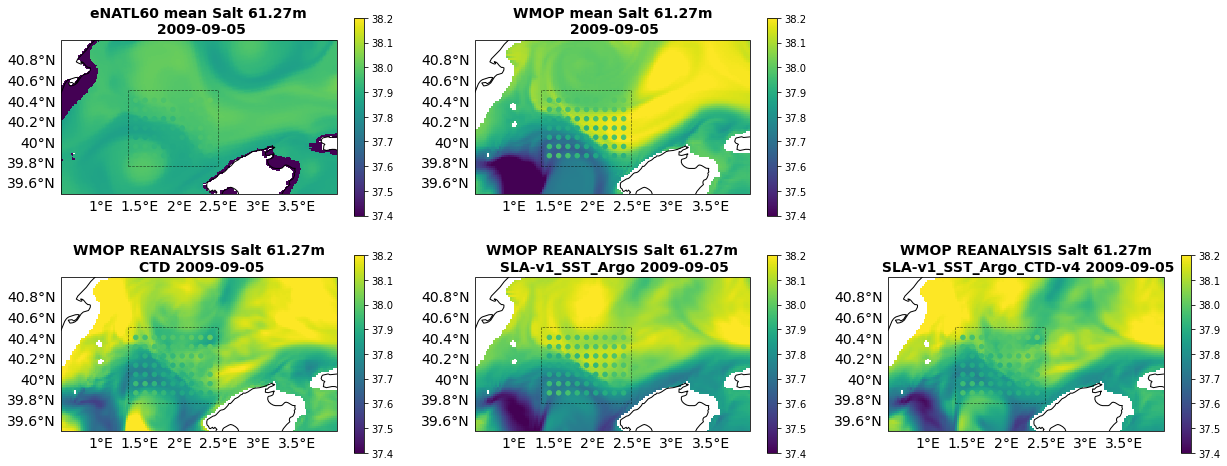

In [196]:
limits = [0.5, 4, 39.5, 41]
#limits= [-6, 9,34.5,44.5]


vmin=37.4
vmax=38.2

i = 2
# Position of Depths
ndepth = [14, 17, 22, 30]

# depths of CTD observations
depth_ctd = ds_obs.dep_ctd.values

# Depth of eNATL for index
depth = natl_salt.vosaline.deptht[ndepth[i]].values
# Temp eNATL at depth
salt_natl = natl_salt.vosaline[:,ndepth[i],:,:].mean(axis=0)
# temp_natl = natl_temp.votemper[:,ndepth[i],:,:].mean(axis=0)
# CTD obs at depth
nd = np.argmin( np.abs(depth_ctd - depth) )
obs_depth = ds_obs.isel(dep_ctd=[nd])
# Temp WMOP at depth
# temp_wmop = pyroms.tools.zslice( ds_wmop['temp'][0,:,:,:].values, depth, grd)[0]
salt_wmop = pyroms.tools.zslice( ds_wmop['salt'][0,:,:,:].values, depth, grd)[0]



#fig_sss = plt.figure(figsize=(23,8))
fig_sss = plt.figure(figsize=(21,8))

# eNATL60
ax, gl = tools.make_map(subplot_dim=231, fsize=14, limits=limits)
plt.pcolormesh( natl_sss.nav_lon, natl_sss.nav_lat, salt_natl / mask_natl.tmaskutil[0,:,:], cmap='viridis',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.sal_ctd[:,0], cmap='viridis', transform=gl.crs, vmin=vmin, vmax=vmax)

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

plt.colorbar()
plt.title(F"eNATL60 mean Salt {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

# WMOP
ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, salt_wmop, cmap='viridis',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.sal_ctd[:,0], cmap='viridis', transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP mean Salt {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)


for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(F"{path_da}{obs_labels[i]}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc")
    salt_da = pyroms.tools.zslice( ds_da['salt'][0,:,:,:].values, depth, grd)[0]


    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, salt_da, cmap='viridis',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.sal_ctd[:,0], cmap='viridis', transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP REANALYSIS Salt {depth:0.2f}m\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)


plt.show()

In [197]:
fig_sss.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/compare_salinity_{depth:0.2f}m_mean_fields_WMOP_REANALYSIS_{date.strftime('%Y%m%d')}.png", dpi=250, transparent=False, facecolor="w")

In [14]:
import matplotlib.ticker as mticker

### Plot Temperature

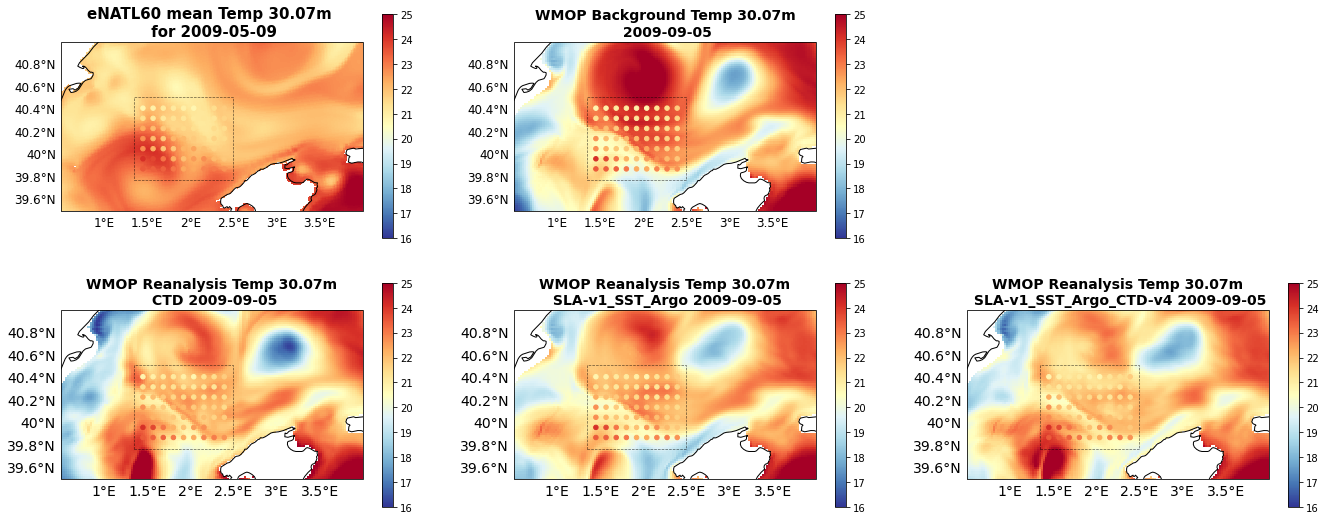

In [160]:
limits = [0.5, 4, 39.5, 41]
vmin, vmax = 25, 27.0

# limits= [-6, 9,34.5,44.5]
# vmin, vmax = 22, 27.0

vmin, vmax = 16, 25
i = 0
# Position of Depths
ndepth = [14, 17, 22, 30]

# depths of CTD observations
depth_ctd = ds_obs.dep_ctd.values

# Depth of eNATL for index
depth = natl_salt.vosaline.deptht[ndepth[i]].values
# Temp eNATL at depth
temp_natl = natl_temp.votemper[:,ndepth[i],:,:].mean(axis=0)
# CTD obs at depth
nd = np.argmin( np.abs(depth_ctd - depth) )
obs_depth = ds_obs.isel(dep_ctd=[nd])
# Temp WMOP at depth
temp_wmop = pyroms.tools.zslice( ds_wmop['temp'][0,:,:,:].values, depth, grd)[0]



fig_temp = plt.figure(figsize=(23,14))

ax, gl = tools.make_map( subplot_dim=331, limits=limits)
plt.pcolormesh( natl_sst.nav_lon, natl_sst.nav_lat, temp_natl / mask_natl.tmaskutil[0,:,:], cmap='RdYlBu_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.tem_ctd[:,0], cmap='RdYlBu_r', transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)
plt.title(F"eNATL60 mean Temp {depth:0.2f}m \n for {date.strftime('%Y-%d-%m')}", fontsize=15, fontweight='bold')


ax, gl = tools.make_map(subplot_dim=332, limits=limits)
plt.pcolormesh( ds_wmop.lon_rho, ds_wmop.lat_rho, temp_wmop, cmap='RdYlBu_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.tem_ctd[:,0], cmap='RdYlBu_r', transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP Background Temp {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')
plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)


for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(F"{path_da}{obs_labels[i]}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc")
    temp_wmop = pyroms.tools.zslice( ds_da['temp'][0,:,:,:].values, depth, grd)[0]

    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(3,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, temp_wmop, cmap='RdYlBu_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.tem_ctd[:,0], cmap='RdYlBu_r', transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP Reanalysis Temp {depth:0.2f}m\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)

plt.show()

In [161]:
fig_temp.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/compare_temp_{depth:0.2f}m_mean_fields_WMOP_REANALYSIS_{date.strftime('%Y%m%d')}.png",
                dpi=250, transparent=False, facecolor="w")

## **AFTER ANALYSIS**

In [149]:
file_temp_natl2 = F"{path_enatl60}/WMED_3D-fields/eNATL60MEDWEST-BLB002_y{date_yesterday.strftime('%Ym%md%d')}.1h_votemper.nc"
file_salt_natl2 = F"{path_enatl60}/WMED_3D-fields/eNATL60MEDWEST-BLB002_y{date_yesterday.strftime('%Ym%md%d')}.1h_vosaline.nc"

natl_temp2 = xr.open_dataset(file_temp_natl2)
natl_salt2 = xr.open_dataset(file_salt_natl2)

file_wmop_bg = glob(F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/{date_yesterday.strftime('%Y/%m/%d')}/*avg.nc")[0]
ds_wmop_bg = xr.open_dataset(file_wmop_bg)


In [150]:
path_an = F"/mnt/vinson/DATA/jhernandez/WMOP_ASSIM/Outputs/EuroSea_OSSE_nudging/{date_yesterday.strftime('%Y%m%d')}/"
path_an

'/mnt/vinson/DATA/jhernandez/WMOP_ASSIM/Outputs/EuroSea_OSSE_nudging/20090904/'

### Plot Temperature

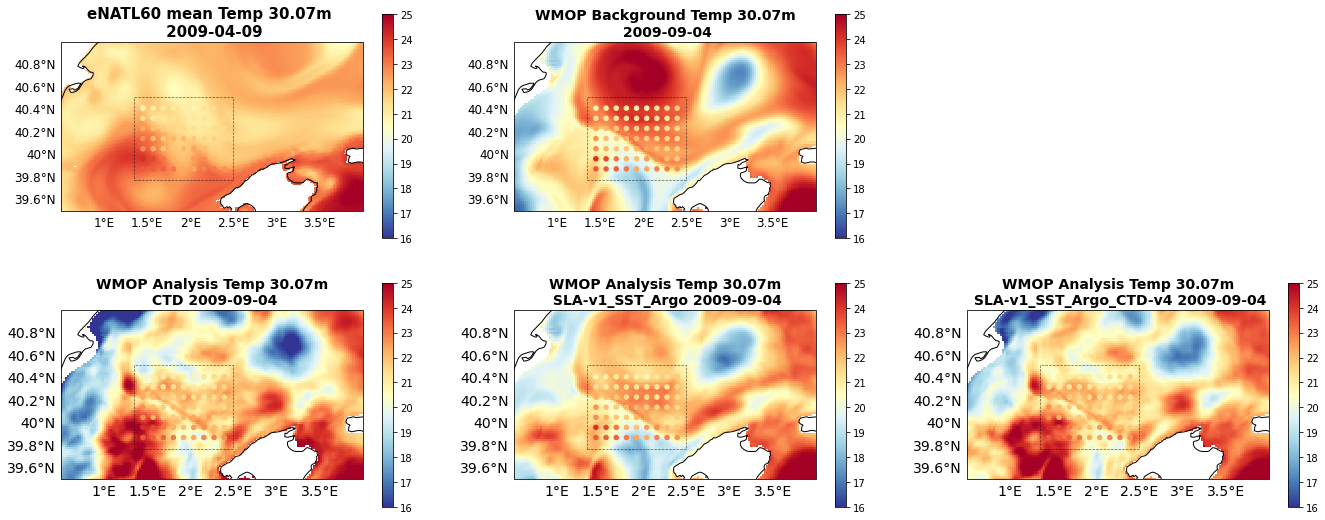

In [158]:
limits = [0.5, 4, 39.5, 41]
vmin, vmax = 25, 27.0

# limits= [-6, 9,34.5,44.5]
# vmin, vmax = 22, 27.0

vmin, vmax = 16, 25
i = 0
# Position of Depths
ndepth = [14, 17, 22, 30]

# depths of CTD observations
depth_ctd = ds_obs.dep_ctd.values

# Depth of eNATL for index
depth = natl_salt2.vosaline.deptht[ndepth[i]].values
# Temp eNATL at depth
temp_natl = natl_temp2.votemper[:,ndepth[i],:,:].mean(axis=0)
# CTD obs at depth
nd = np.argmin( np.abs(depth_ctd - depth) )
obs_depth = ds_obs.isel(dep_ctd=[nd])
# Temp WMOP at depth
temp_wmop = pyroms.tools.zslice( ds_wmop_bg['temp'][0,:,:,:].values, depth, grd)[0]



fig_temp_an = plt.figure(figsize=(23,14))

ax, gl = tools.make_map( subplot_dim=331, limits=limits)
plt.pcolormesh( natl_sst.nav_lon, natl_sst.nav_lat, temp_natl / mask_natl.tmaskutil[0,:,:], cmap='RdYlBu_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.tem_ctd[:,0], cmap='RdYlBu_r', transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)
plt.title(F"eNATL60 mean Temp {depth:0.2f}m \n {date_yesterday.strftime('%Y-%d-%m')}", fontsize=15, fontweight='bold')


ax, gl = tools.make_map(subplot_dim=332, limits=limits)
plt.pcolormesh( ds_wmop.lon_rho, ds_wmop.lat_rho, temp_wmop, cmap='RdYlBu_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.tem_ctd[:,0], cmap='RdYlBu_r', transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP Background Temp {depth:0.2f}m\n {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')
plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)


for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
    temp_wmop = pyroms.tools.zslice( ds_da['temp'][0,:,:,:].values, depth, grd)[0]

    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(3,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, temp_wmop, cmap='RdYlBu_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.tem_ctd[:,0], cmap='RdYlBu_r', transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP Analysis Temp {depth:0.2f}m\n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)

plt.show()

In [159]:
fig_temp_an.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/compare_temp_{depth:0.2f}m_mean_fields_WMOP_ANALYSIS_{date.strftime('%Y%m%d')}.png",
                dpi=250, transparent=False, facecolor="w")

### Plot Salinity

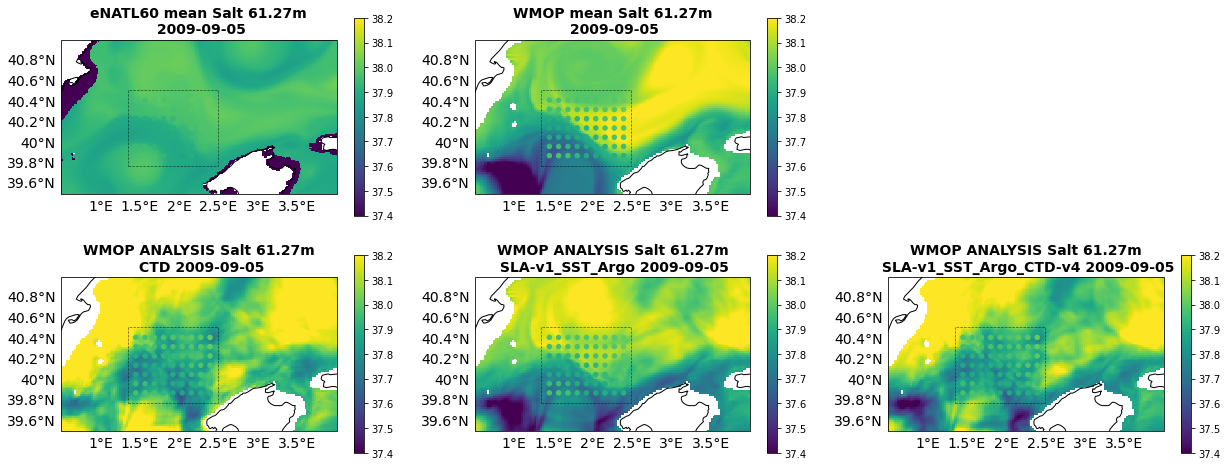

In [194]:
limits = [0.5, 4, 39.5, 41]
#limits= [-6, 9,34.5,44.5]

vmin=37.4
vmax=38.2

i = 2
# Position of Depths
ndepth = [14, 17, 22, 30]

# depths of CTD observations
depth_ctd = ds_obs.dep_ctd.values

# Depth of eNATL for index
depth = natl_salt2.vosaline.deptht[ndepth[i]].values
# Temp eNATL at depth
salt_natl = natl_salt2.vosaline[:,ndepth[i],:,:].mean(axis=0)
# temp_natl = natl_temp.votemper[:,ndepth[i],:,:].mean(axis=0)
# CTD obs at depth
nd = np.argmin( np.abs(depth_ctd - depth) )
obs_depth = ds_obs.isel(dep_ctd=[nd])
# Salt WMOP at depth
salt_wmop = pyroms.tools.zslice( ds_wmop_bg['salt'][0,:,:,:].values, depth, grd)[0]



fig_salt_an = plt.figure(figsize=(21,8))

# eNATL60
ax, gl = tools.make_map(subplot_dim=231, fsize=14, limits=limits)
plt.pcolormesh( natl_sss.nav_lon, natl_sss.nav_lat, salt_natl / mask_natl.tmaskutil[0,:,:], cmap='viridis',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.sal_ctd[:,0], cmap='viridis', transform=gl.crs, vmin=vmin, vmax=vmax)

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

plt.colorbar()
plt.title(F"eNATL60 mean Salt {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

# WMOP
ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, salt_wmop, cmap='viridis',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.sal_ctd[:,0], cmap='viridis', transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP mean Salt {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)


for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
    salt_da = pyroms.tools.zslice( ds_da['salt'][0,:,:,:].values, depth, grd)[0]


    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, salt_da, cmap='viridis',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, obs_depth.sal_ctd[:,0], cmap='viridis', transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP ANALYSIS Salt {depth:0.2f}m\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)


plt.show()

In [195]:
fig_salt_an.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/compare_salinity_{depth:0.2f}m_mean_fields_WMOP_ANALYSIS_{date.strftime('%Y%m%d')}.png",
                dpi=250, transparent=False, facecolor="w")

## SST

In [ ]:
obs_labels = ['CTD', 'SLA-v1_SST_Argo', 'SLA-v1_SST_Argo_CTD-v4']
path_da = '/mnt/vinson/DATA/jhernandez/ROMS/Outputs/EuroSea_OSSE_nudging/'
path_an = F"/mnt/vinson/DATA/jhernandez/WMOP_ASSIM/Outputs/EuroSea_OSSE_nudging/{date_yesterday.strftime('%Y%m%d')}/"

In [344]:
i=0
obs_label = obs_labels[i]

In [349]:

# Get Backgorund fields
ds_bg = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_forecast_{obs_labels[i]}_un*nc")[0])
# Get Analysis fields
ds_an = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])

# Get Nudging fields
ds_nd = xr.open_dataset(F"{path_da}{obs_labels[i]}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc")

# Observations
df_obs = tools.get_innovations(glob(F"{path_an}/inn*{obs_labels[i]}_un*")[0],
                               glob(F"{path_an}/obs*{obs_labels[i]}_un*")[0])
#df_obs_sst = df_obs[df_obs['source'].str.contains('SST')].reset_index(drop=True)
df_obs_sla = df_obs[df_obs['nb_sou']==5].reset_index(drop=True)

### Plot SST

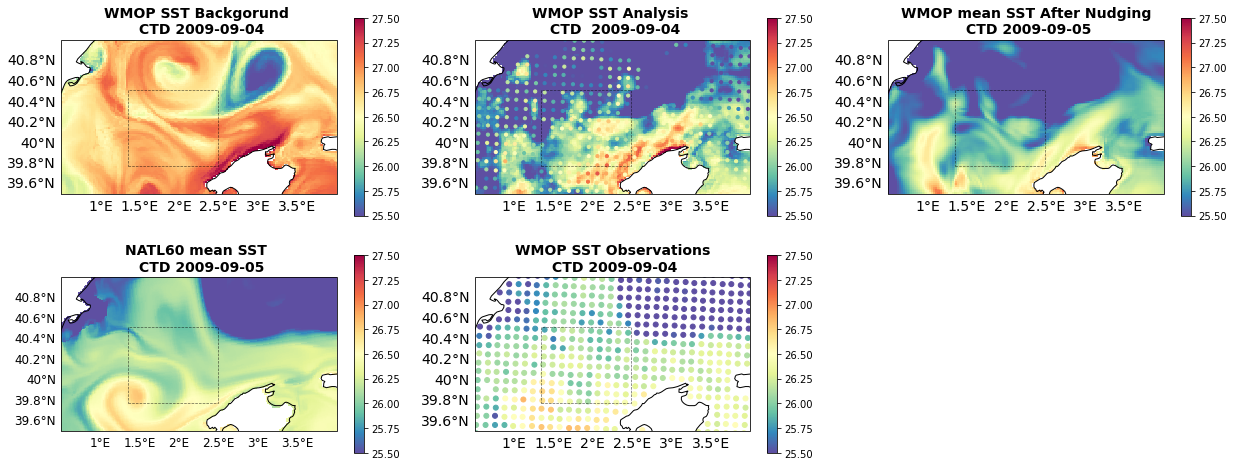

In [350]:
vmin, vmax = 25.5, 27.5


fig_sst = plt.figure(figsize=(21,8))

# WMOP Background
ax, gl = tools.make_map(subplot_dim=231, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, ds_bg.temp[0,-1,:,:], cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(df_obs_sst.lon, df_obs_sst.lat, 10, df_obs_sst.background, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP SST Backgorund \n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

# WMOP Observations
ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, ds_an.temp[0,-1,:,:], cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(df_obs_sst.lon, df_obs_sst.lat, 10, df_obs_sst.analysis, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP SST Analysis \n {obs_label}  {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

# WMOP Nudging
ax, gl = tools.make_map(subplot_dim=233, fsize=14, limits=limits)
plt.pcolormesh( ds_nd.lon_rho, ds_nd.lat_rho, ds_nd.temp[0,-1,:,:], cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP mean SST After Nudging\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

# NATL60
ax, gl = tools.make_map( subplot_dim=234, limits=limits)
plt.pcolormesh( natl_sst.nav_lon, natl_sst.nav_lat, natl_temp2.votemper[:,0,:,:].mean(axis=0) / mask_natl.tmaskutil[0,:,:], cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"NATL60 mean SST \n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)



# WMOP Observations
ax, gl = tools.make_map(subplot_dim=235, fsize=14, limits=limits)
plt.scatter(df_obs_sst.lon, df_obs_sst.lat, 25, df_obs_sst.val, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP SST Observations\n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

plt.show()

In [351]:
fig_sst.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/SST_comparison_NR-Obs-backgorund-analysis-afternudging_{date.strftime('%Y%m%d')}_{obs_label}.png",
                dpi=250, transparent=False, facecolor="w")

## SLA

### Get NATL SLA

In [636]:
file_natl_mdt = 'https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/dodsC/meomopendap/extract/lerouste/Eurosea2022/pseudo-ssh-alongtrack/DATA_src/eNATL60MEDWEST-BLB002_y2020-21_TM.nc'
mdt_natl = xr.open_dataset(file_natl_mdt)

# Define path eNATL60
file_ssh_natl = F"/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y2009m{date_yesterday.strftime('%md%d')}.1h_sossheig.nc"

# Load SSH Dataset
natl_zos = xr.open_dataset(file_ssh_natl)

ssh_natl = ds_ssh.sossheig.mean(axis=0)
sla = ssh_natl - mdt_natl.sossheig
sla = sla.where(sla>-1)


### Plot SLA

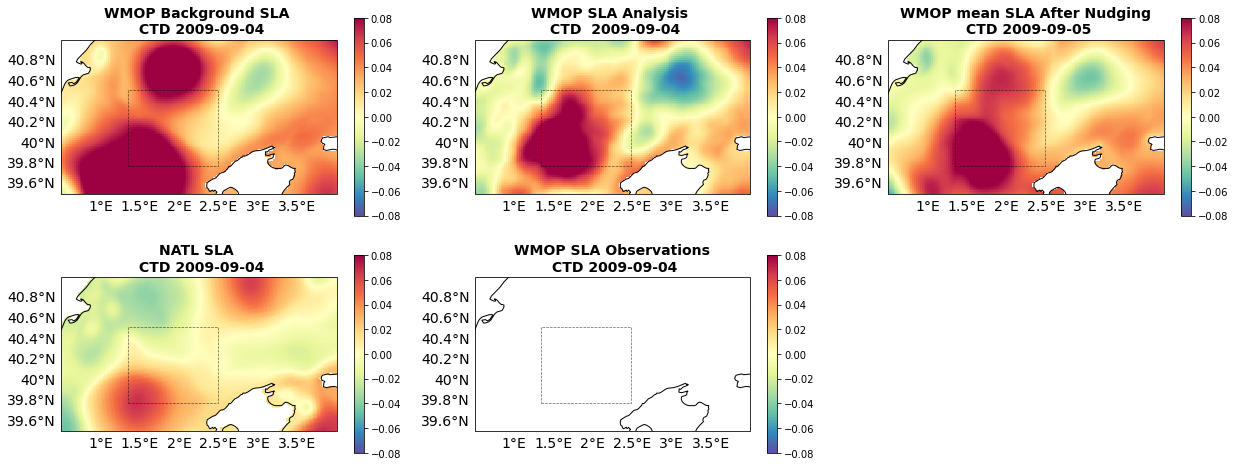

In [353]:
vmin, vmax = -0.08, 0.08


fig_sla = plt.figure(figsize=(21,8))

# WMOP Background
ax, gl = tools.make_map(subplot_dim=231, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, ds_bg.zeta[0,:,:].values - ds_wmop_mdt.zeta[0,:,:].values, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(df_obs_sla.lon, df_obs_sla.lat, 15, df_obs_sla.background, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP Background SLA \n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)


# WMOP Analysis
ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, ds_an.zeta[0,:,:].values - ds_wmop_mdt.zeta[0,:,:].values, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(df_obs_sla.lon, df_obs_sla.lat, 25, df_obs_sla.analysis, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP SLA Analysis \n {obs_label}  {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

# WMOP Observations
ax, gl = tools.make_map(subplot_dim=235, fsize=14, limits=limits)
plt.scatter(df_obs_sla.lon, df_obs_sla.lat, 25, df_obs_sla.val, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP SLA Observations\n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

# WMOP Background
ax, gl = tools.make_map(subplot_dim=234, fsize=14, limits=limits)
plt.pcolormesh(mask_natl.nav_lon, mask_natl.nav_lat, sla - np.nanmean(sla) , 
               transform=gl.crs, vmin=vmin, vmax=vmax, cmap='Spectral_r')
plt.scatter(df_obs_sla.lon, df_obs_sla.lat, 25, df_obs_sla.val, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"NATL SLA \n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

# WMOP Nudging
ax, gl = tools.make_map(subplot_dim=233, fsize=14, limits=limits)
plt.pcolormesh( ds_nd.lon_rho, ds_nd.lat_rho, ds_nd.zeta[0,:,:].values - ds_wmop_mdt.zeta[0,:,:].values, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP mean SLA After Nudging\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

plt.show()

In [354]:
fig_sla.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/SLA_comparison_NR-Obs-backgorund-analysis-afternudging_{date.strftime('%Y%m%d')}_{obs_label}.png",
                dpi=250, transparent=False, facecolor="w")

### Plot SLA Comparison - Analysis

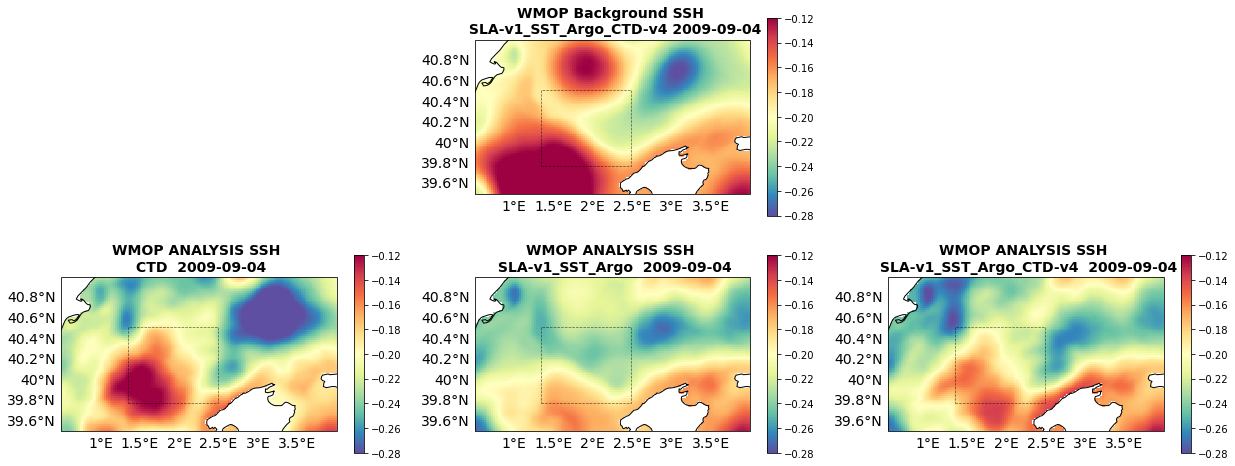

In [634]:
vmin, vmax = -0.28, -0.12


fig_sla_an = plt.figure(figsize=(21,8))

# # NATL60
# ax, gl = tools.make_map(subplot_dim=231, fsize=14, limits=limits)
# plt.pcolormesh(mask_natl.nav_lon, mask_natl.nav_lat, sla - np.nanmean(sla) , 
#                transform=gl.crs, vmin=vmin, vmax=vmax, cmap='Spectral_r')
# plt.colorbar()
# plt.title(F"NATL SLA \n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

# plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
#         [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
#         transform=gl.crs)

# WMOP Background
ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, ds_bg.zeta[0,:,:].values, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(df_obs_sla.lon, df_obs_sla.lat, 15, df_obs_sla.background, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP Background SSH \n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

for i, obs_label in enumerate(obs_labels):

    ds_an = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])

    # WMOP Analysis
    ax, gl = tools.make_map(subplot_dim=(2,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, ds_an.zeta[0,:,:].values, cmap='Spectral_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP ANALYSIS SSH \n {obs_label}  {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)


plt.show()

### Plot SLA Comparison - Afeter Nudging

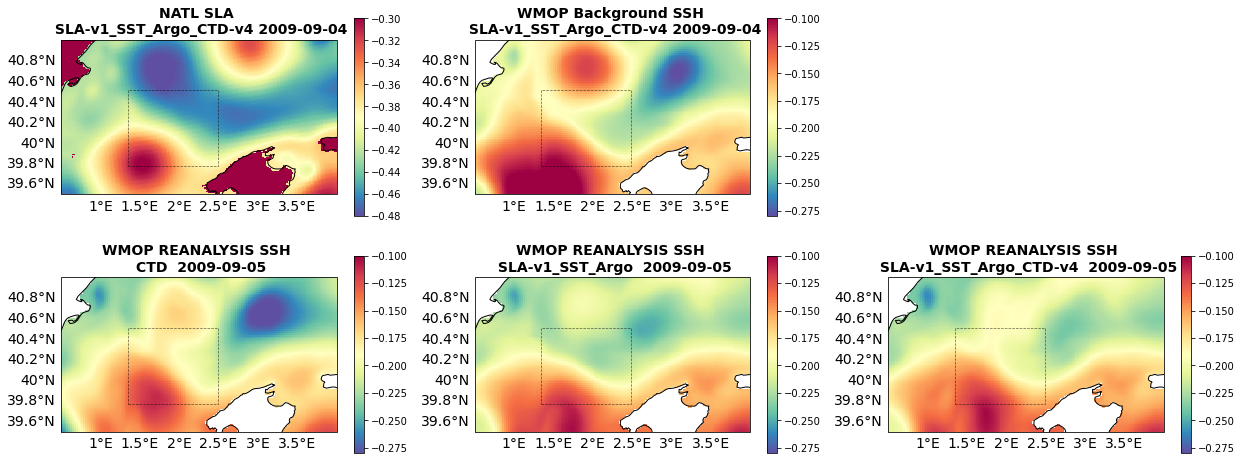

In [642]:
vmin, vmax = -0.28, -0.10


fig_sla_an = plt.figure(figsize=(21,8))

# NATL60
ax, gl = tools.make_map(subplot_dim=231, fsize=14, limits=limits)
plt.pcolormesh(mask_natl.nav_lon, mask_natl.nav_lat, ssh_natl , 
               transform=gl.crs, vmin=vmin-0.2, vmax=vmax-0.2, cmap='Spectral_r')
plt.colorbar()
plt.title(F"NATL SLA \n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

# WMOP Background
ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, ds_bg.zeta[0,:,:].values, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(df_obs_sla.lon, df_obs_sla.lat, 15, df_obs_sla.background, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP Background SSH \n {obs_label} {date_yesterday.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(F"{path_da}{obs_labels[i]}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc")

    # WMOP Analysis
    ax, gl = tools.make_map(subplot_dim=(2,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, ds_da.zeta[0,:,:].values, cmap='Spectral_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP REANALYSIS SSH \n {obs_label}  {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)


plt.show()

## Density

In [355]:
import seawater as sw

In [397]:

i = 0
# Position of Depths
ndepth = [14, 17, 22, 30]

# depths of CTD observations
depth_ctd = ds_obs.dep_ctd.values

# Depth of eNATL for index
depth = natl_salt2.vosaline.deptht[ndepth[i]].values

# Temp eNATL at depth
salt_natl = natl_salt2.vosaline[:,ndepth[i],:,:].mean(axis=0)
temp_natl = natl_temp.votemper[:,ndepth[i],:,:].mean(axis=0)
dens_natl = sw.dens(salt_natl, temp_natl, depth)

# CTD obs at depth
nd = np.argmin( np.abs(depth_ctd - depth) )
obs_depth = ds_obs.isel(dep_ctd=[nd])
dens_ctd = sw.dens( obs_depth.sal_ctd[:,0], obs_depth.tem_ctd[:,0], depth)

# Salt WMOP at depth
temp_wmop = pyroms.tools.zslice( ds_wmop_bg['temp'][0,:,:,:].values, depth, grd)[0]
salt_wmop = pyroms.tools.zslice( ds_wmop_bg['salt'][0,:,:,:].values, depth, grd)[0]

dens_wmop = sw.dens(salt_wmop, temp_wmop, depth)

### Plot Analysis Density 

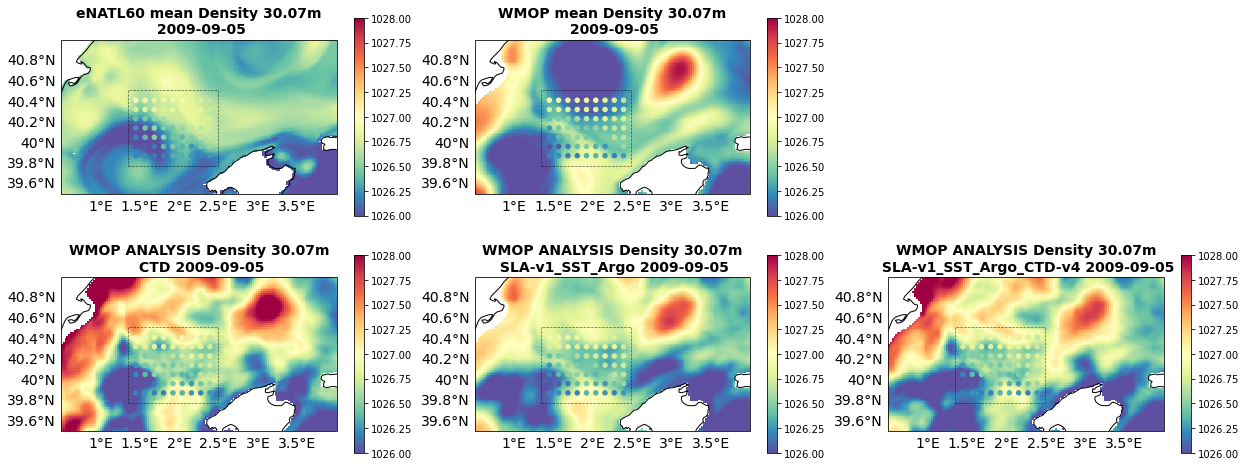

In [398]:
limits = [0.5, 4, 39.5, 41]
#limits= [-6, 9,34.5,44.5]

vmin, vmax = 1026.0, 1028.0
fig_dens_an = plt.figure(figsize=(21,8))

# eNATL60
ax, gl = tools.make_map(subplot_dim=231, fsize=14, limits=limits)
plt.pcolormesh( natl_sss.nav_lon, natl_sss.nav_lat, dens_natl / mask_natl.tmaskutil[0,:,:], cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, dens_ctd, cmap='Spectral_r', transform=gl.crs, vmin=vmin, vmax=vmax)

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

plt.colorbar()
plt.title(F"eNATL60 mean Density {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

# WMOP
ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, dens_wmop, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, dens_ctd, cmap='Spectral_r', transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP mean Density {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
    temp_da = pyroms.tools.zslice( ds_da['temp'][0,:,:,:].values, depth, grd)[0]
    salt_da = pyroms.tools.zslice( ds_da['salt'][0,:,:,:].values, depth, grd)[0]

    dens_da = sw.dens(salt_da, temp_da, depth)

    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, dens_da, cmap='Spectral_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, dens_ctd, cmap='Spectral_r', transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP ANALYSIS Density {depth:0.2f}m\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)


plt.show()

In [399]:
fig_dens_an.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/compare_density_{depth:0.2f}m_mean_fields_WMOP_ANALYSIS_{date.strftime('%Y%m%d')}.png",
                dpi=250, transparent=False, facecolor="w")

### Plot After Nudging Density 

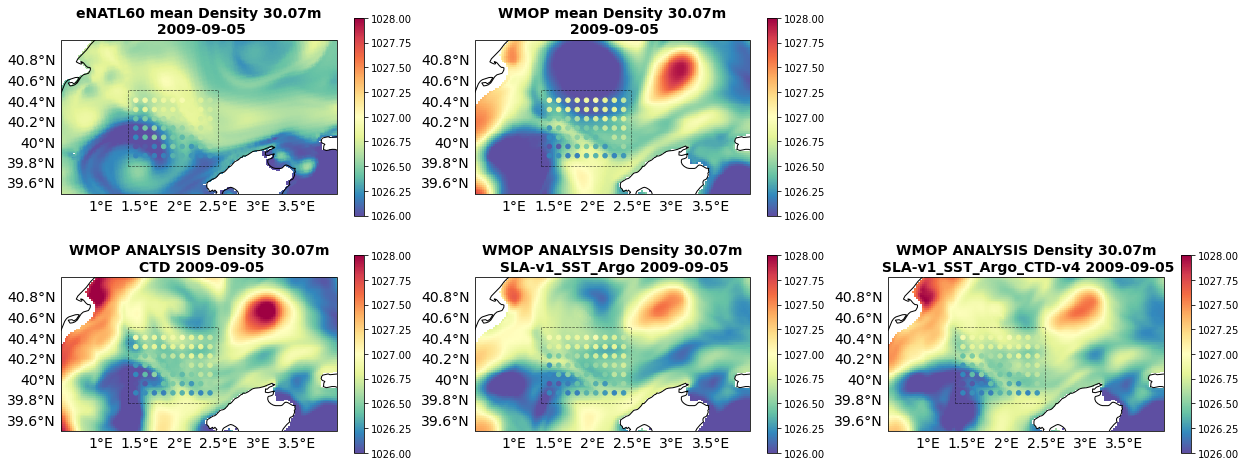

In [400]:
# vmin, vmax = 1027.5, 1029
fig_dens_ng = plt.figure(figsize=(21,8))

# eNATL60
ax, gl = tools.make_map(subplot_dim=231, fsize=14, limits=limits)
plt.pcolormesh( natl_sss.nav_lon, natl_sss.nav_lat, dens_natl / mask_natl.tmaskutil[0,:,:], cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, dens_ctd, cmap='Spectral_r', transform=gl.crs, vmin=vmin, vmax=vmax)

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

plt.colorbar()
plt.title(F"eNATL60 mean Density {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

# WMOP
ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, dens_wmop, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, dens_ctd, cmap='Spectral_r', transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP mean Density {depth:0.2f}m\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(F"{path_da}{obs_labels[i]}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc")
    temp_da = pyroms.tools.zslice( ds_da['temp'][0,:,:,:].values, depth, grd)[0]
    salt_da = pyroms.tools.zslice( ds_da['salt'][0,:,:,:].values, depth, grd)[0]

    dens_da = sw.dens(salt_da, temp_da, depth)

    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( ds_da.lon_rho, ds_da.lat_rho, dens_da, cmap='Spectral_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.scatter(obs_depth.lon_ctd, obs_depth.lat_ctd, 20, dens_ctd, cmap='Spectral_r', transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP ANALYSIS Density {depth:0.2f}m\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)


plt.show()

In [401]:
fig_dens_ng.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/compare_density_{depth:0.2f}m_mean_fields_WMOP_REANALYSIS_{date.strftime('%Y%m%d')}.png", dpi=250, transparent=False, facecolor="w")

## **Dynamic Height**

In [428]:
z_r = grd.vgrid.z_r[:][:,nlat_min:nlat_max, nlon_min:nlon_max]

(32, 82, 147)

In [591]:
from scipy.interpolate import interp1d
# limits = [0.45, 4.5, 39.0, 41.5]

def dinamic_height(ds, grid, limits = limits):
      
    nlon_min = np.argmin(np.abs(ds.lon_rho[0,:].values - limits[0]))
    nlon_max = np.argmin(np.abs(ds.lon_rho[0,:].values - limits[1]))
    nlat_min = np.argmin(np.abs(ds.lat_rho[:,0].values - limits[2]))
    nlat_max = np.argmin(np.abs(ds.lat_rho[:,0].values - limits[3]))
    
    salt = ds.salt[0,:,nlat_min:nlat_max, nlon_min:nlon_max]
    temp = ds.temp[0,:,nlat_min:nlat_max, nlon_min:nlon_max]
    
    lon_wmop = ds_wmop.lon_rho[nlat_min:nlat_max, nlon_min:nlon_max]
    lat_wmop = ds_wmop.lat_rho[nlat_min:nlat_max, nlon_min:nlon_max]
    
    z_r = grid.vgrid.z_r[:][:,nlat_min:nlat_max, nlon_min:nlon_max]
    z_interp = [5, 10, 15, 20, 25, 30, 40, 50, 70, 100, 125, 150, 175, 200, 250, 300, 400, 500]#, 600, 700, 800]
    
    ny, nx = salt.shape[1:]
    dheight = np.empty((len(z_interp), ny, nx))
    for i in range(ny):
        for j in range(nx):

            ft = interp1d(np.flip(-z_r[:,i,j]), np.flip(temp[:,i,j].values), fill_value="extrapolate")
            tij = ft(z_interp)
            fs = interp1d(np.flip(-z_r[:,i,j]), np.flip( salt[:,i,j].values ), fill_value="extrapolate" )
            sij = fs(z_interp)

            dheight[:,i,j] = sw.gpan(sij, tij, z_interp ) 

    return dheight, lon_wmop, lat_wmop

### Plot DH Analysis

In [601]:
dheight = {}

# WMOP
dheight['CR'], lon_wmop, lat_wmop = dinamic_height(ds_wmop_bg, grd, limits = limits)

for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
    dheight[obs_label], lon_wmop, lat_wmop = dinamic_height(ds_da, grd, limits = limits)

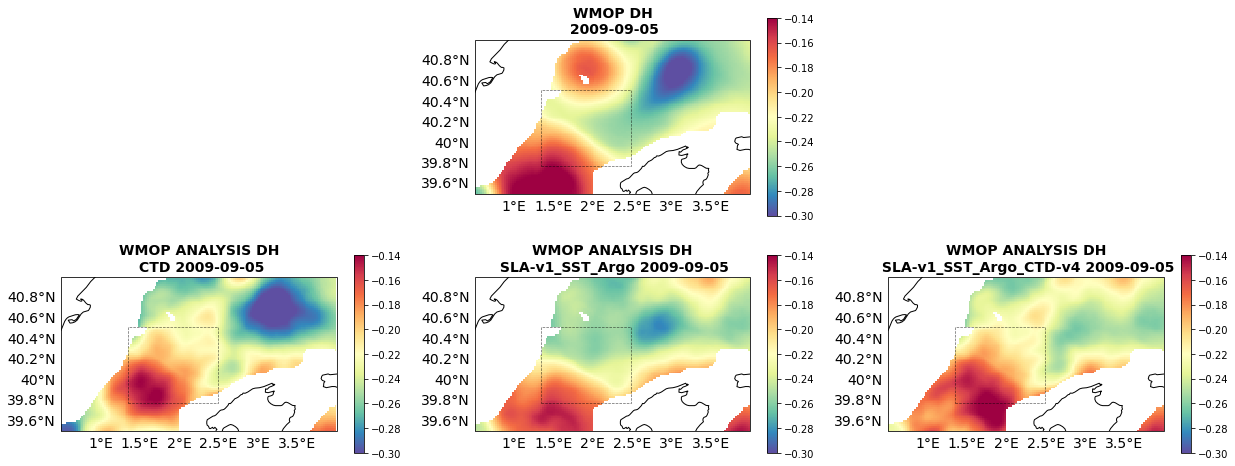

In [605]:
limits = [0.5, 4, 39.5, 41]
#limits= [-6, 9,34.5,44.5]

vmin, vmax = -0.3, -0.14
fig_dh_an = plt.figure(figsize=(21,8))

# WMOP
# dheight, lon_wmop, lat_wmop = dinamic_height(ds_wmop_bg, grd, limits = limits)
dh = np.copy(dheight['CR'][-1,:,:]) / 10
dh[zz < 800] = np.nan

ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( lon_wmop, lat_wmop, dh, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP DH\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

for i, obs_label in enumerate(obs_labels):

#     ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
#     dheight = dinamic_height(ds_da, grd, limits = limits)
    dh = np.copy(dheight[obs_label][-1,:,:]) / 10
    dh[zz < 800] = np.nan
    
    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( lon_wmop, lat_wmop, dh, cmap='Spectral_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP ANALYSIS DH\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)


plt.show()

In [606]:
fig_dh_an.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/compare_DinamicHeight_mean_fields_WMOP_ANALYSIS_{date.strftime('%Y%m%d')}.png", dpi=250, transparent=False, facecolor="w")

### Plot DH After Nudging

In [604]:
dheight_nd = {}

# WMOP
dheight_nd['CR'], lon_wmop, lat_wmop = dinamic_height(ds_wmop_bg, grd, limits = limits)

for i, obs_label in enumerate(obs_labels):

    ds_da = xr.open_dataset(F"{path_da}{obs_labels[i]}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc")
    dheight_nd[obs_label], lon_wmop, lat_wmop = dinamic_height(ds_da, grd, limits = limits)

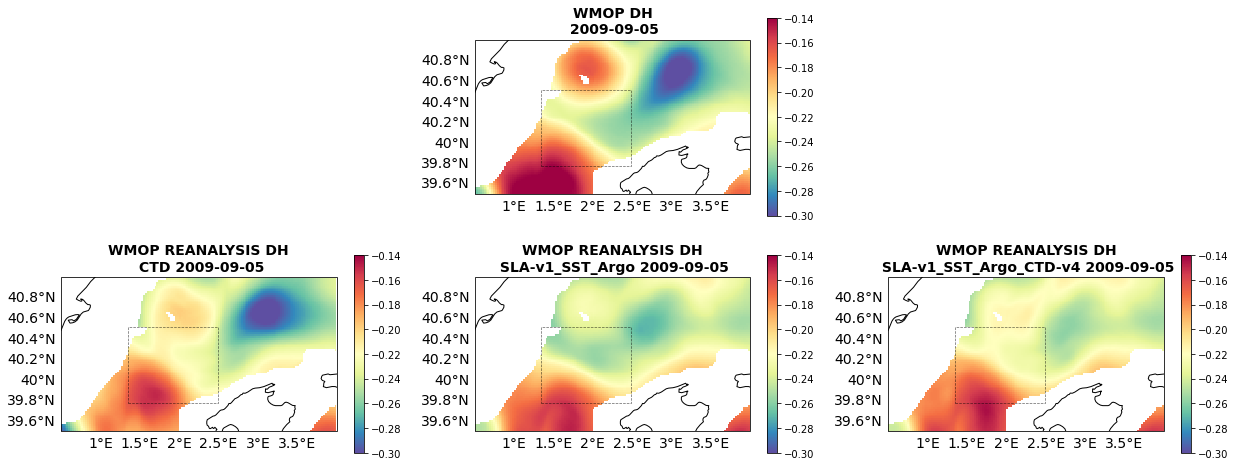

In [607]:
limits = [0.5, 4, 39.5, 41]
#limits= [-6, 9,34.5,44.5]

vmin, vmax = -0.3, -0.14
fig_dh_ng = plt.figure(figsize=(21,8))

# WMOP
#dheight = dinamic_height(ds_wmop_bg, grd, limits = limits)
dh = np.copy(dheight_nd['CR'][-1,:,:]) / 10
dh[zz < 800] = np.nan

ax, gl = tools.make_map(subplot_dim=232, fsize=14, limits=limits)
plt.pcolormesh( lon_wmop, lat_wmop, dh, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(F"WMOP DH\n {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
        [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
        transform=gl.crs)

for i, obs_label in enumerate(obs_labels):

    #ds_da = xr.open_dataset(F"{path_da}{obs_labels[i]}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc")
    #dheight = dinamic_height(ds_da, grd, limits = limits)
    dh = np.copy(dheight_nd[obs_label][-1,:,:]) / 10
    dh[zz < 800] = np.nan
    
    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+4), fsize=14, limits=limits)
    plt.pcolormesh( lon_wmop, lat_wmop, dh, cmap='Spectral_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP REANALYSIS DH\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

    plt.plot([limits_obs[0], limits_obs[1], limits_obs[1], limits_obs[0], limits_obs[0]],
            [limits_obs[2], limits_obs[2], limits_obs[3], limits_obs[3], limits_obs[2]],'k--', alpha=0.6, linewidth=0.7,
            transform=gl.crs)


plt.show()

In [608]:
fig_dh_ng.savefig(F"/LOCALDATA/Plots/EuroSea/WP2/compare_DinamicHeight_mean_fields_WMOP_REANALYSIS_{date.strftime('%Y%m%d')}.png", dpi=250, transparent=False, facecolor="w")